In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
# sys.path.insert(0, '../..')
sys.path.insert(0, '/content/drive/My Drive/Docs universidad/University/2020-2/Redes Neuronales y Teoría de la información para el aprendizaje/Proyecto/Repositorio Paper 1')
sys.path.insert(0, '/content/drive/My Drive/Docs universidad/University/2020-2/Redes Neuronales y Teoría de la información para el aprendizaje/Proyecto/Repositorio Paper 1/notebooks/bivariate-categorical')

In [3]:
!python -m pip install -r '/content/drive/My Drive/Docs universidad/University/2020-2/Redes Neuronales y Teoría de la información para el aprendizaje/Proyecto/Repositorio Paper 1/requirements.txt'

     |███████████████                 | 278.6MB 1.5MB/s eta 0:03:25ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 425, in _error_catcher
    yield
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/urllib3/response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.6/http/client.py", line 459, in read
    n = self.readinto(b)
  File "/usr/lib/python3.6/http/client.py", line 503, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.6/socket.py", line 586, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.6/ssl.py", line 1012, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.6/ssl.py", line 874, in read
    return self._sslobj.read(len, buffer)

In [10]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook

from causal_meta.utils.data_utils import generate_data_categorical
from models import StructuralModel

In [5]:
N = 10
model = StructuralModel(N, dtype=torch.float64)

In [6]:
num_episodes = 500
batch_size = 100 # 1
num_test = 10000
num_training = 10 # 100
num_transfers = 10 # 100

In [7]:
optimizer = torch.optim.SGD(model.modules_parameters(), lr=1.)

In [8]:
losses = np.zeros((2, num_training, num_transfers, num_episodes))

for k in tnrange(num_training):
    pi_A_1 = np.random.dirichlet(np.ones(N))
    pi_B_A = np.random.dirichlet(np.ones(N), size=N)
    for j in tnrange(num_transfers, leave=False):
        model.set_ground_truth(pi_A_1, pi_B_A)
        pi_A_2 = np.random.dirichlet(np.ones(N))
        x_val = torch.from_numpy(generate_data_categorical(num_test, pi_A_2, pi_B_A))
        for i in range(num_episodes):
            x_transfer = torch.from_numpy(generate_data_categorical(batch_size, pi_A_2, pi_B_A))
            model.zero_grad()
            loss_A_B = -torch.mean(model.model_A_B(x_transfer))
            loss_B_A = -torch.mean(model.model_B_A(x_transfer))
            loss = loss_A_B + loss_B_A
            
            with torch.no_grad():
                val_loss_A_B = -torch.mean(model.model_A_B(x_val))
                val_loss_B_A = -torch.mean(model.model_B_A(x_val))

            losses[:, k, j, i] = [val_loss_A_B.item(), val_loss_B_A.item()]

            loss.backward()
            optimizer.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


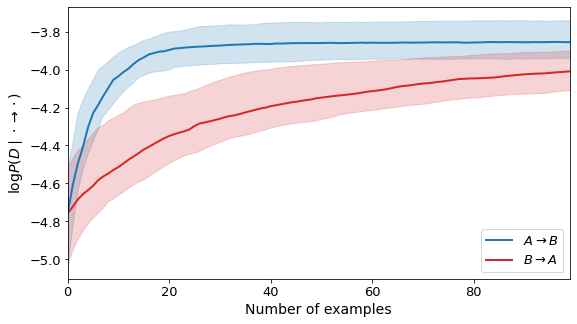

In [11]:
flat_losses = -losses.reshape((2, -1, num_episodes))
losses_25, losses_50, losses_75 = np.percentile(flat_losses, (25, 50, 75), axis=1)

plt.figure(figsize=(9, 5))

ax = plt.subplot(1, 1, 1)
ax.plot(losses_50[0], color='C0', label=r'$A \rightarrow B$', lw=2)
ax.fill_between(np.arange(num_episodes), losses_25[0], losses_75[0], color='C0', alpha=0.2)
ax.plot(losses_50[1], color='C3', label=r'$B \rightarrow A$', lw=2)
ax.fill_between(np.arange(num_episodes), losses_25[1], losses_75[1], color='C3', alpha=0.2)
ax.set_xlim([0, flat_losses.shape[1] - 1])
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc=4, prop={'size': 13})
ax.set_xlabel('Number of examples', fontsize=14)
ax.set_ylabel(r'$\log P(D\mid \cdot \rightarrow \cdot)$', fontsize=14)

plt.show()